In [1]:
!pip install pareto

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pareto
import math

In [3]:
dataset = 'ft' # 'ml100k', 'ml1m', 'ft', 'anime'

## Frente de pareto

Load GridSearch results:

In [4]:
df = {}
for m in ['ResBeMF', 'BeMF', 'DirMF', 'PMF', 'MLP']:
    aux = pd.read_csv('results/gridsearch/' + dataset + '/' + m.lower() +'.csv')
    aux = aux[aux['cummulativemae_avg'] >= 0.05]
    aux = aux[aux['cummulativecoverage_avg'] >= 0.05]
    df[m] = aux

Plot the scatter:

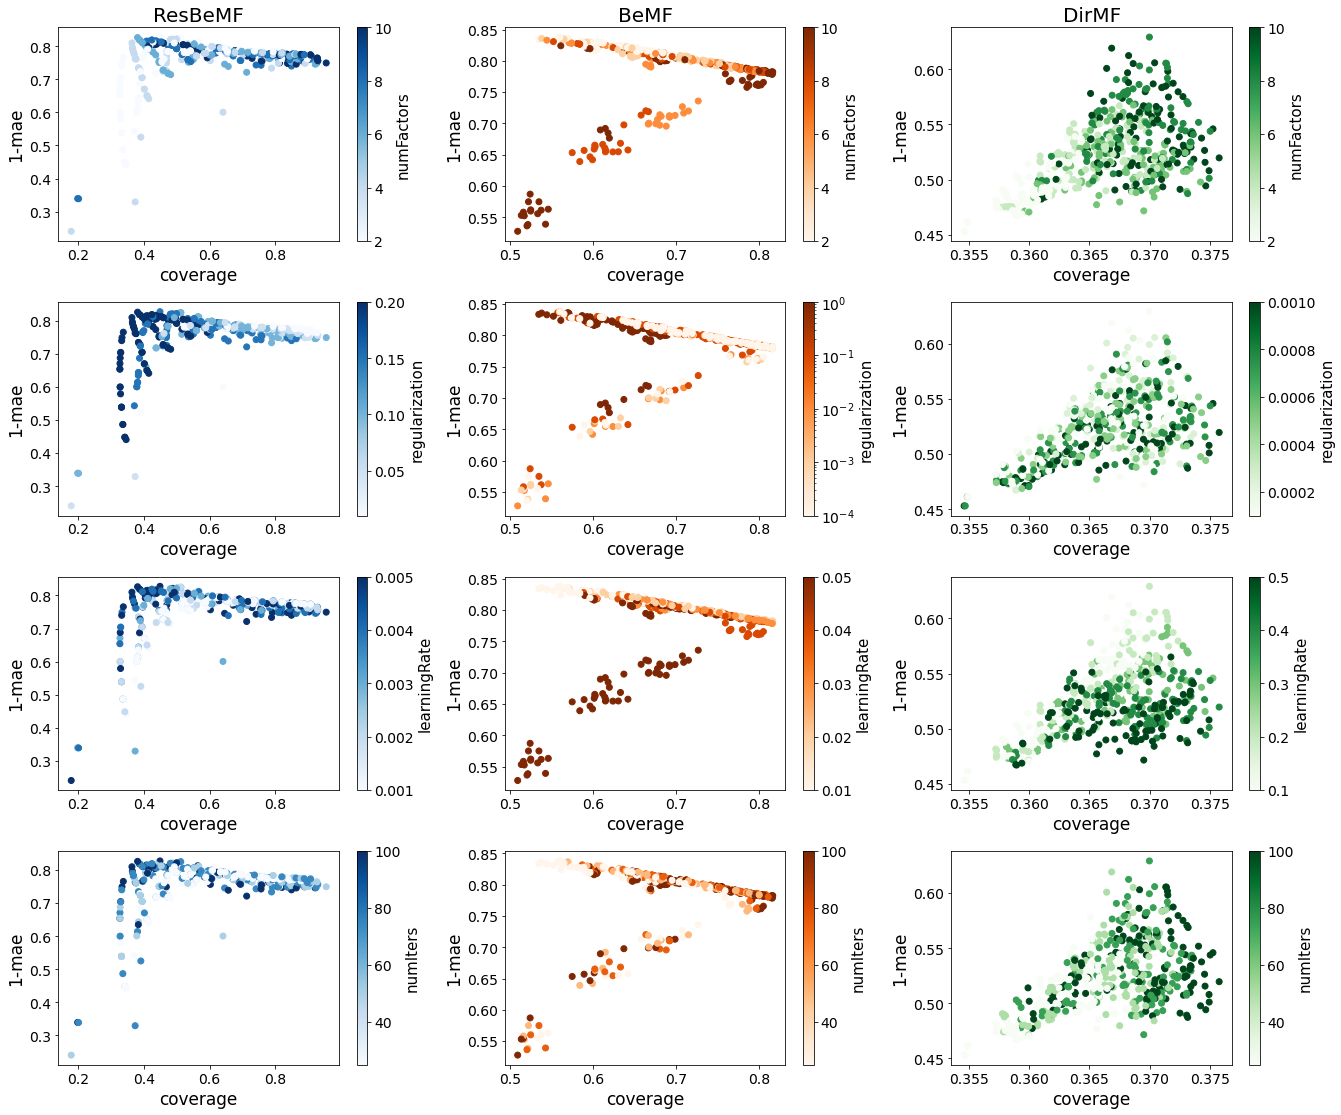

In [5]:
params = ['numFactors', 'regularization', 'learningRate', 'numIters']
methods = ['ResBeMF', 'BeMF', 'DirMF']
cmaps = ['Blues', 'Oranges', 'Greens']

fig, axs = plt.subplots(len(params), len(methods), figsize=(6*len(methods),3.75*len(params)))
fig.tight_layout(h_pad=4, w_pad=6.5)

for i, param in enumerate(params):
    for j, method in enumerate(methods):
        
        axs[i,j].set_xlabel('coverage', fontsize=17)
        axs[i,j].set_ylabel('1-mae', fontsize=17)
        
        if i == 0:
            axs[i,j].set_title(method, fontsize=20)
            
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)
            
        mae = df[method]['cummulativemae_avg']
        coverage = df[method]['cummulativecoverage_avg']
        color = df[method][param] 
                    
        norm = colors.LogNorm(vmin=color.min(), vmax=color.max()) if param == 'regularization' and (method == 'BeMF' or (method == 'ResBeMF' and dataset == 'anime')) else None
        
        im = axs[i,j].scatter(coverage, mae, c=color, cmap=cmaps[j], norm=norm)
        
        cbar = plt.colorbar(im, ax=axs[i,j])
        cbar.set_label(param, fontsize=15)
        cbar.ax.tick_params(labelsize=14)
        
plt.savefig('./figs/' + dataset + '-hyperparameters.png', dpi=300, bbox_inches='tight')

Plot the pareto fronts:

In [6]:
def get_pareto_front(df):
    objectives = [df.columns.get_loc(c) for c in ['cummulativemae_avg', 'cummulativecoverage_avg'] if c in df]
    nondominated = pareto.eps_sort([list(df.itertuples(False))], objectives, maximize_all=True)
    pareto_front = pd.DataFrame.from_records(nondominated, columns=list(df.columns.values))
    s = sorted(zip(pareto_front['cummulativecoverage_avg'], pareto_front['cummulativemae_avg']))
    cov, mae = [list(tuple) for tuple in zip(*s)]
    return cov, mae

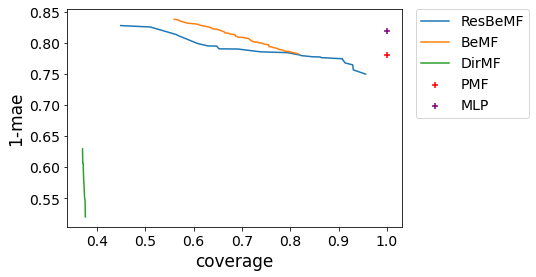

In [7]:
resbemf_coverage, resbemf_mae = get_pareto_front(df['ResBeMF'])
plt.plot(resbemf_coverage, resbemf_mae, label='ResBeMF')

bemf_coverage, bemf_mae = get_pareto_front(df['BeMF'])
plt.plot(bemf_coverage, bemf_mae, label='BeMF')

dirmf_coverage, dirmf_mae = get_pareto_front(df['DirMF'])
plt.plot(dirmf_coverage, dirmf_mae, label='DirMF')

pmf_coverage, pmf_mae = get_pareto_front(df['PMF'])
plt.scatter(pmf_coverage, pmf_mae, label='PMF', c='red', marker='+')

mlp_coverage, mlp_mae = get_pareto_front(df['MLP'])
plt.scatter(mlp_coverage, mlp_mae, label='MLP', c='purple', marker='+')

plt.xlabel('coverage', fontsize=17)
plt.xticks(fontsize=14)

plt.ylabel('1-mae', fontsize=17)
plt.yticks(fontsize=14)
    
plt.legend(fontsize=14, loc=(1.04, 0.5))

plt.savefig('./figs/' + dataset + '-pareto-front.png', dpi=300, bbox_inches='tight')

## Test split error

Load test split results:

In [8]:
mae_df = pd.read_csv('results/test-split/' + dataset + '/mae.csv')
mae_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,DirMF_6,DirMF_7,DirMF_8,DirMF_9,DirMF_10,DirMF_11,DirMF_12,DirMF_13,PMF,MLP
0,0.00,0.763592,0.768070,0.757533,0.782340,0.714286,0.753223,0.759018,0.714286,0.769105,...,0.787775,0.795001,0.793971,0.795956,0.787818,0.800181,0.786401,0.784992,0.768908,0.793416
1,0.05,0.763592,0.768070,0.757533,0.782340,0.714286,0.753223,0.759018,0.714286,0.769105,...,0.787775,0.795001,0.793971,0.795956,0.787818,0.800181,0.786401,0.784992,0.768908,0.793416
2,0.15,0.764011,0.768596,0.757567,0.782621,0.714286,0.753290,0.759018,0.714286,0.769845,...,0.795074,0.802707,0.800005,0.802536,0.789641,0.804214,0.795850,0.793379,0.768908,0.793416
3,0.20,0.769630,0.775539,0.764796,0.800389,0.714286,0.758651,0.759032,0.714286,0.781188,...,0.821629,0.826446,0.817388,0.821235,0.831706,0.815331,0.831956,0.826685,0.768908,0.793416
4,0.25,0.777975,0.781611,0.770062,0.815665,0.714286,0.764404,0.766320,0.714286,0.784127,...,0.875279,0.861599,0.852663,0.848179,0.859469,0.842857,0.832288,0.858197,0.768908,0.793416
5,0.30,0.782195,0.785540,0.775930,0.830909,0.714286,0.768764,0.770444,0.714286,0.791819,...,0.923077,0.804762,0.828157,0.895604,0.791667,0.702381,0.886905,0.897959,0.768908,0.793416
6,0.35,0.779071,0.788276,0.779594,0.838353,NaN,0.775179,0.780299,NaN,0.802418,...,1.000000,NaN,0.500000,1.000000,0.678571,NaN,1.000000,1.000000,0.768908,0.793416
7,0.40,0.785014,0.787702,0.783155,0.846945,NaN,0.777184,0.788408,NaN,0.816416,...,NaN,NaN,0.285714,NaN,NaN,NaN,NaN,NaN,0.768908,0.793416
8,0.45,0.785269,0.816238,0.797693,0.907732,NaN,0.783434,0.791901,NaN,0.846604,...,NaN,NaN,0.285714,NaN,NaN,NaN,NaN,NaN,0.768908,0.793416
9,0.50,0.790385,0.831202,0.797519,0.899007,NaN,0.786419,0.794690,NaN,0.870279,...,NaN,NaN,0.285714,NaN,NaN,NaN,NaN,NaN,0.768908,0.793416


In [9]:
coverage_df = pd.read_csv('results/test-split/' + dataset + '/coverage.csv')
coverage_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,DirMF_6,DirMF_7,DirMF_8,DirMF_9,DirMF_10,DirMF_11,DirMF_12,DirMF_13,PMF,MLP
0,0.00,1.000000,1.000000,1.000000,1.000000,0.002381,1.000000,1.000000,0.002381,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
1,0.05,1.000000,1.000000,1.000000,1.000000,0.002381,1.000000,1.000000,0.002381,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
2,0.15,0.997852,0.996593,0.999923,0.986877,0.002381,0.999860,1.000000,0.002381,0.993566,...,0.920499,0.908507,0.917602,0.928688,0.923579,0.928129,0.917580,0.913426,1,1
3,0.20,0.943181,0.950465,0.956622,0.772822,0.002381,0.971226,0.985257,0.002381,0.927562,...,0.415076,0.377489,0.411430,0.420713,0.417317,0.406498,0.426602,0.413844,1,1
4,0.25,0.897394,0.887248,0.899251,0.481149,0.002381,0.927298,0.928626,0.002381,0.806616,...,0.075835,0.083663,0.074573,0.086060,0.097027,0.077554,0.109016,0.087151,1,1
5,0.30,0.856276,0.815998,0.811090,0.323741,0.002381,0.885672,0.837845,0.002381,0.622156,...,0.005546,0.007296,0.010890,0.003563,0.005247,0.002681,0.009946,0.009888,1,1
6,0.35,0.771888,0.653556,0.698905,0.191025,0.000000,0.810098,0.723118,0.000000,0.433315,...,0.000132,0.000000,0.001850,0.000428,0.000706,0.000000,0.000132,0.000132,1,1
7,0.40,0.673367,0.480228,0.610742,0.129313,0.000000,0.716630,0.625497,0.000000,0.289116,...,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
8,0.45,0.581506,0.311545,0.520954,0.085199,0.000000,0.633842,0.531478,0.000000,0.161420,...,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
9,0.50,0.484531,0.198291,0.437471,0.048544,0.000000,0.543328,0.449098,0.000000,0.078561,...,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,1,1


Remove mae values computed with a coverage less than 0.01:

In [10]:
for c in mae_df.columns.tolist()[1:]:
    for i in range(mae_df['reliability'].size):
        if coverage_df[c][i] <= 0.01:
            mae_df[c][i] = math.nan

Compute aveage error and its std:

In [11]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    mae_df[method + "_mean"] = mae_df.loc[:, mae_df.columns.str.startswith(method)].mean(axis=1)
    mae_df[method + "_std"] = mae_df.loc[:, mae_df.columns.str.startswith(method)].std(axis=1)

In [12]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    coverage_df[method + "_mean"] = coverage_df.loc[:, coverage_df.columns.str.startswith(method)].mean(axis=1)
    coverage_df[method + "_std"] = coverage_df.loc[:, coverage_df.columns.str.startswith(method)].std(axis=1)

Plot the figure:

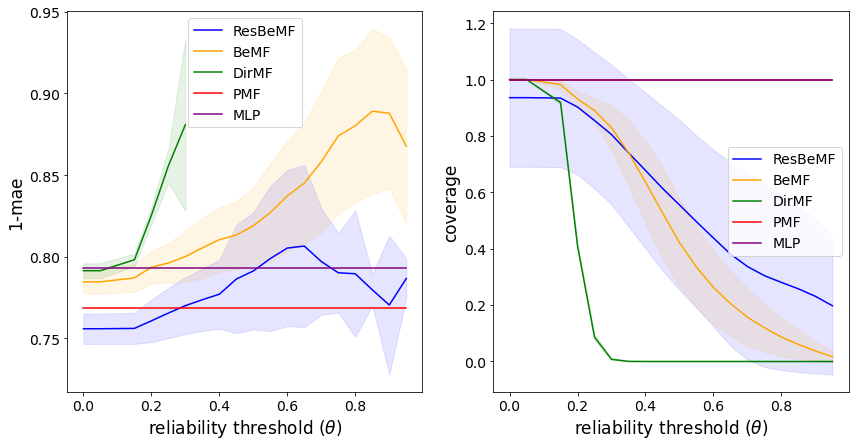

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14,7))

def plot_axis(df, name, ax):
    ax.set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    ax.set_ylabel(name, fontsize=17)

    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.fill_between(df['reliability'], df['ResBeMF_mean'] + df['ResBeMF_std'], df['ResBeMF_mean'] - df['ResBeMF_std'], color='blue', alpha=0.1)
    ax.plot(df['reliability'], df['ResBeMF_mean'], c='blue', label='ResBeMF')

    ax.fill_between(df['reliability'], df['BeMF_mean'] + df['BeMF_std'], df['BeMF_mean'] - df['BeMF_std'], color='orange', alpha=0.1)
    ax.plot(df['reliability'], df['BeMF_mean'], c='orange', label='BeMF')

    ax.fill_between(df['reliability'], df['DirMF_mean'] + df['DirMF_std'], df['DirMF_mean'] - df['DirMF_std'], color='green', alpha=0.1)
    ax.plot(df['reliability'], df['DirMF_mean'], c='green', label='DirMF')
    
    ax.plot(df['reliability'], df['PMF'], c='red', label='PMF')

    ax.plot(df['reliability'], df['MLP'], c='purple', label='MLP')

    ax.legend(fontsize=14)
    
plot_axis(mae_df, '1-mae', axs[0])
plot_axis(coverage_df, 'coverage', axs[1])

plt.savefig('./figs/' + dataset + '-test-error.png', dpi=300, bbox_inches='tight')